# Baseline model

## ARIMA Model

In [1]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
%load_ext autoreload
%autoreload 2

### Import data

In [3]:
from electricity_price_predictor.data import get_price, get_shifted_price

In [4]:
df= get_shifted_price()
df.head()

,price
time,
2015-01-01 00:00:00,25.02
2015-01-01 01:00:00,18.29
2015-01-01 02:00:00,16.04
2015-01-01 03:00:00,14.60
2015-01-01 04:00:00,14.95


### Decomposition of hourly data

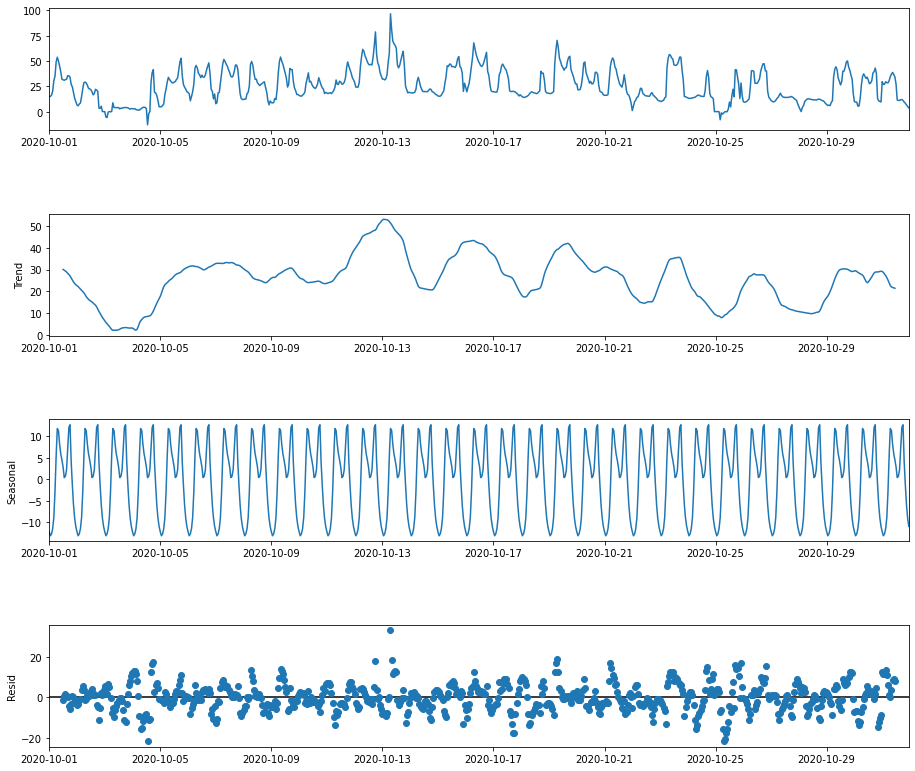

In [5]:
df_2020_10 = df[(df.index.year==2020) & (df.index.month==10)]
decompose_2020_10 = seasonal_decompose(df_2020_10, model='additive')
fig = decompose_2020_10.plot()
fig.set_size_inches(14, 12);

### Decomposition of df_hour_11

In [6]:
# get all the data for 11 am 
df_hour_11 = df[df.index.hour==11]
df_hour_11.head()

,price
time,
2015-01-01 11:00:00,16.08
2015-01-02 11:00:00,15.08
2015-01-03 11:00:00,22.31
2015-01-04 11:00:00,27.32
2015-01-05 11:00:00,40.97


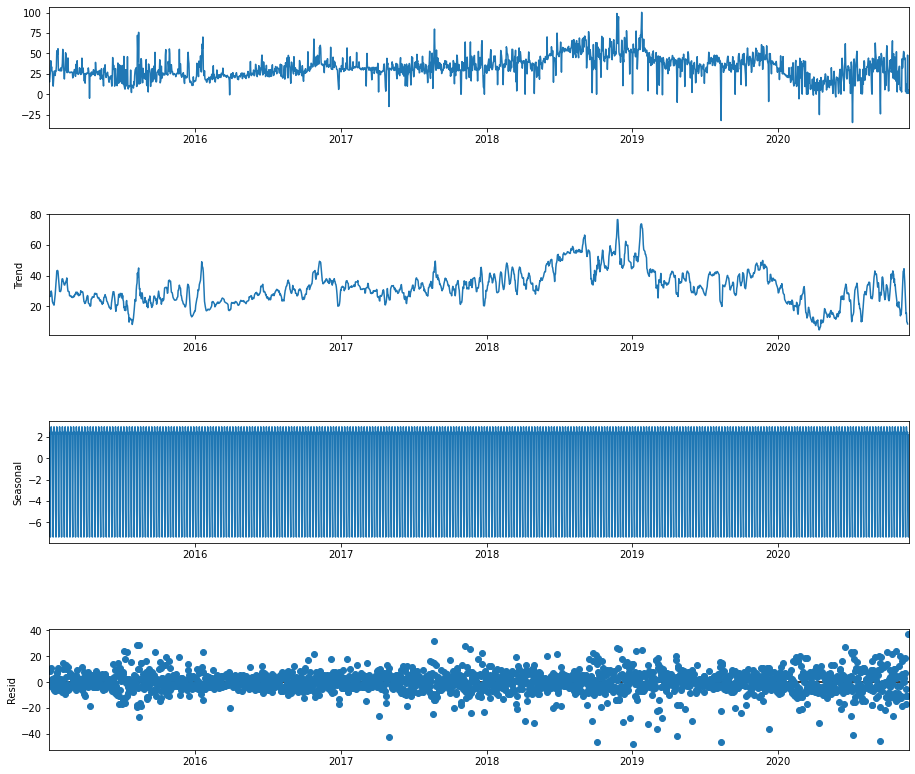

In [7]:
# for 5 years
decompose_5y = seasonal_decompose(df_hour_11, model='additive')
fig = decompose_5y.plot()
fig.set_size_inches(14, 12);

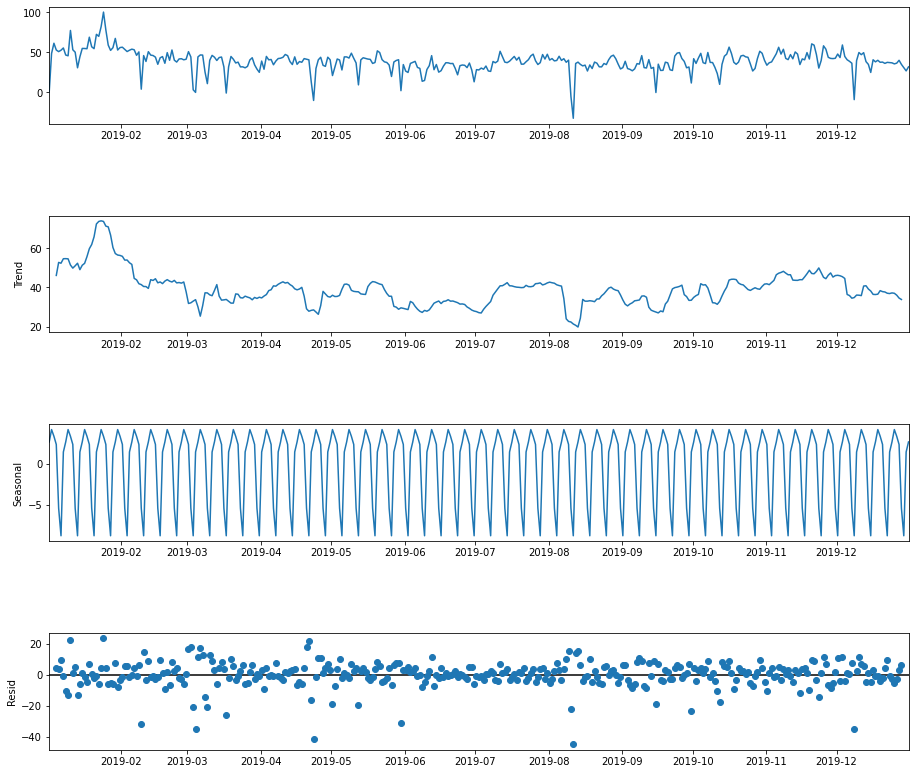

In [8]:
# for year 2019 
decompose_2019 = seasonal_decompose(df_hour_11[(df_hour_11.index.year==2019)], model='additive')
fig = decompose_2019.plot()
fig.set_size_inches(14, 12);

- No clear monthly or yearly seasonality is observed.
- There is a clear weekly seasonality, which is likely caused by electricity usage in household

### Explore the stationarity

In [9]:
# remove the weekly seasonality
df_hour_11_deseasonalized = pd.DataFrame((df_hour_11.price - decompose_5y.seasonal), columns=['price'])

Text(0.5, 1.0, 'First order diff of deseasonalized series')

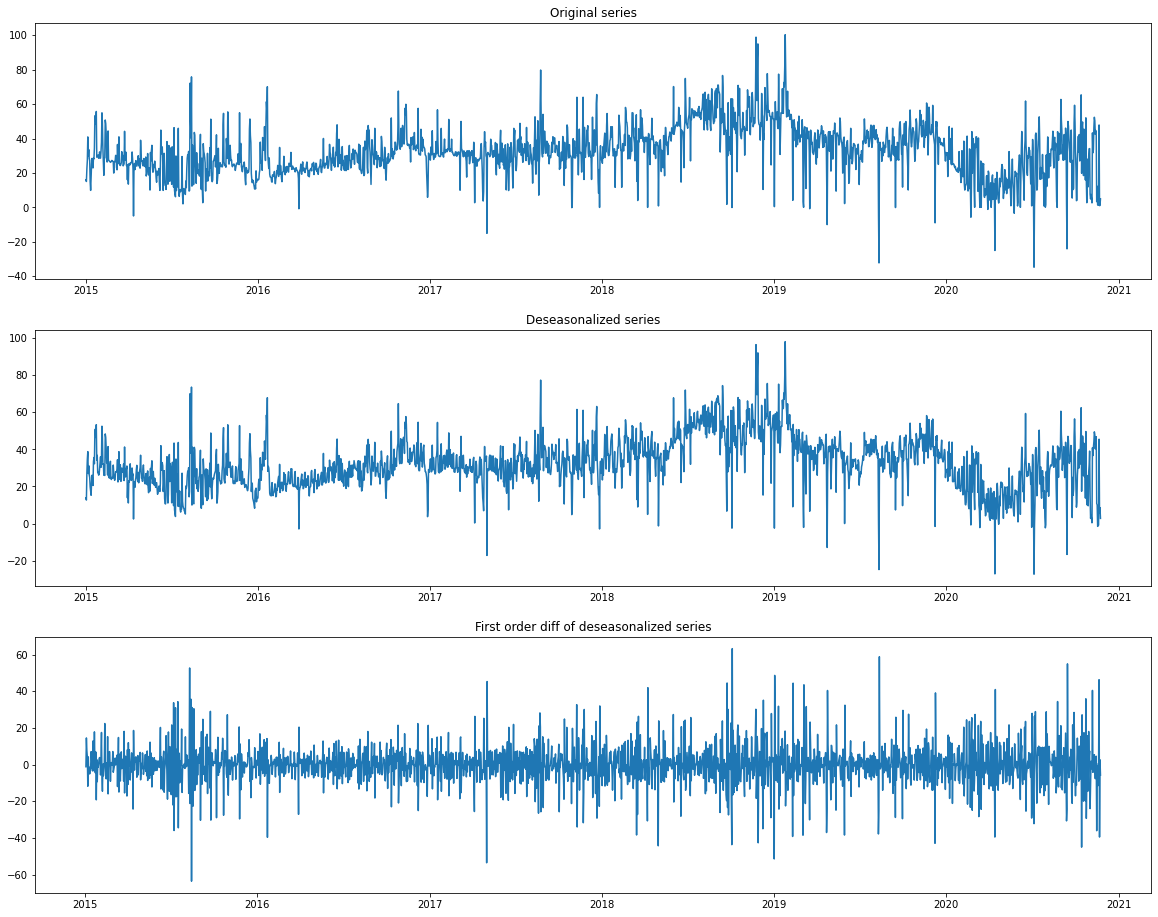

In [10]:
# Explore stationarity of deseasonalized data

fig, axs = plt.subplots(3, 1, figsize=(20,16))
# Original series
axs[0].plot(df_hour_11)
axs[0].set_title('Original series')

# Deseasonalized Series
axs[1].plot(df_hour_11_deseasonalized) 
axs[1].set_title('Deseasonalized series')

# Week + Normal differencing
axs[2].plot(df_hour_11_deseasonalized.diff(1))
axs[2].set_title('First order diff of deseasonalized series')

In [11]:
# ADF test
print('ADF of deseasonalized data: ', adfuller(df_hour_11_deseasonalized)[1])
print('ADF of first order diff deseasonalized data: ', adfuller(df_hour_11_deseasonalized.diff(1).dropna())[1])

ADF of deseasonalized data:  0.011862953608666961
ADF of first order diff deseasonalized data:  9.452731282679423e-28


### Autocorrelation

#### Original series

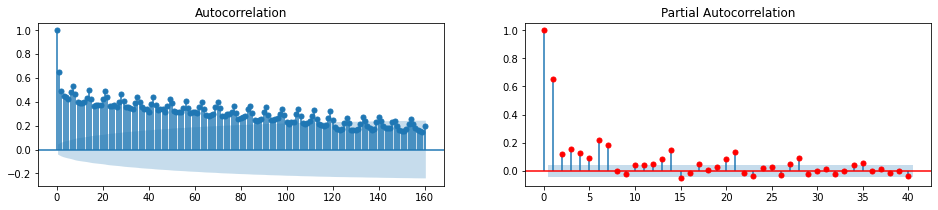

In [12]:
# plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11, lags=160, ax=axes[0]);
plot_pacf(df_hour_11, lags=40, ax=axes[1], color='r');

- ACF shows weekly seasonality and one timepoint is correlated with pass 120 timepoints even more
- PACF also shows weekly seasonality

#### After removing weekly seasonality

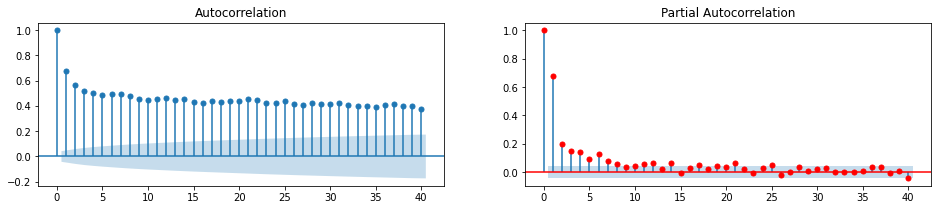

In [13]:
# ACF and PACF after removing weekly seasonality
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11_deseasonalized, lags=40, ax=axes[0]);
plot_pacf(df_hour_11_deseasonalized, lags=40, ax=axes[1], color='r');

- Both ACF show slow gradual decrease, should consider first order diff 

#### After removing weekly seasonality and perform first order diff

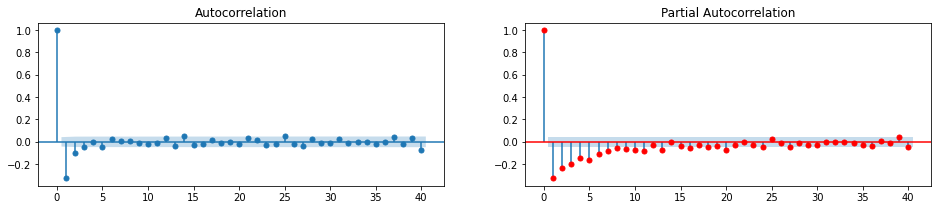

In [14]:
# ACF and PACF after removing weekly seasonality
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11_deseasonalized.diff(1).dropna(), lags=40, ax=axes[0]);
plot_pacf(df_hour_11_deseasonalized.diff(1).dropna(), lags=40, ax=axes[1], color='r');

- According to ACF and PACF, (p, d, q) = (1~7, 1, 1) 

### ARIMA model based on ACF and PACF

In [15]:
# grid search the hyper params
import pmdarima as pm
smodel = pm.auto_arima(df_hour_11_deseasonalized, seasonal=False, 
                       start_p=0, max_p=2, 
                       d=1,
                       start_q=0, max_q=2, 
                       trace=True) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16475.953, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16234.258, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15973.860, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16473.953, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15803.768, Time=0.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15804.834, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15804.785, Time=1.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15833.976, Time=0.57 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16116.062, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15805.243, Time=2.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15801.789, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15971.868, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16232.259, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=15802.856, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0

In [16]:
from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(df_hour_11_deseasonalized, order=(1,1,1), freq='D')
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                 2153
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7897.884
Method:                       css-mle   S.D. of innovations              9.479
Date:                Thu, 26 Nov 2020   AIC                          15803.768
Time:                        22:52:00   BIC                          15826.466
Sample:                    01-02-2015   HQIC                         15812.071
                         - 11-23-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0031      0.022     -0.145      0.885      -0.045       0.039
ar.L1.D.price     0.3672      0.024     15.173      0.000       0.320       0.415
ma.L1.D.price    -0.9335      0.010    -89.974      0.000      -0.954      -0.913
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.7232           +0.0000j            2.7232            0.0000
MA.1            1.0712           +0.0000j            1.0712            0.0000
-----------------------------------------------------------------------------
"""

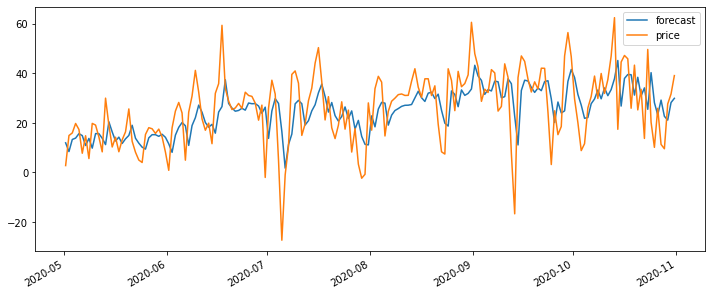

In [17]:
arima.plot_predict('2020-05', '2020-10')
fig = plt.gcf() 
fig.set_size_inches(12, 5);

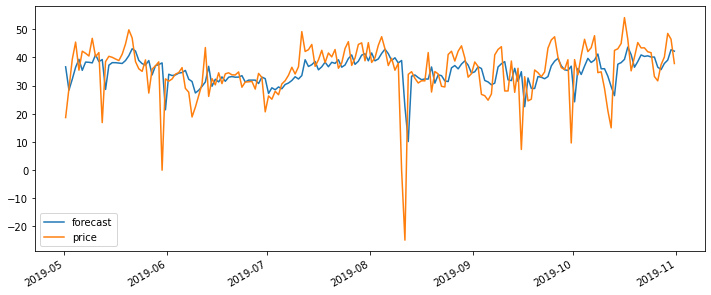

In [18]:
arima.plot_predict('2019-05', '2019-10')
fig = plt.gcf() 
fig.set_size_inches(12, 5);

### Evaluate the model

In [19]:
# Create a correct Training/Test split to predict the last 50 points
train = df_hour_11[df_hour_11.index <= '2019-10-22 11:00:00']
test = df_hour_11[(df_hour_11.index > '2019-10-22 11:00:00') & \
                  (df_hour_11.index < '2019-11-20 11:00:00')]

In [97]:
# Decomposition
decompose = seasonal_decompose(train, model='additive')
train_decompose = pd.DataFrame((train.price - decompose.seasonal), columns=['price'])

In [140]:
# Train the Model
arima = ARIMA(train_decompose, order=(1, 1, 1), freq='D')
arima = arima.fit()
# Forecast
forecast, std_err, confidence_int = arima.forecast(len(test), alpha=0.05)  # 95% confidence

In [141]:
# define a function for re-compose forecast and confident-intervals

def re_compose(forecast):
    '''take forecast price and confidence_intervals as input, returns re-composed forecast price and confident_int'''
    forecast = pd.DataFrame(forecast, index=test.index, columns=['price'])
    forecast['dayofweek'] = forecast.index.dayofweek
    # get the base price of day of week
    week_price = decompose.seasonal.to_frame().set_index(decompose.seasonal.index.dayofweek).drop_duplicates()
    # add the base price to the forecast price
    for i in range(7):
        value = week_price.loc[i, 'seasonal']
        forecast[forecast.dayofweek == i] = forecast[forecast.dayofweek == i] +value
        forecast['dayofweek'] = forecast.index.dayofweek
    forecast.drop(columns=['dayofweek'], inplace=True)
    return forecast    

In [142]:
# define a function for plotting the forecast

def plot_forecast(forecast, train, test, lower_int, upper_int):
    fc = forecast
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(forecast, label='forecast', color='orange')
    plt.fill_between(forecast.index, lower_int, upper_int, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

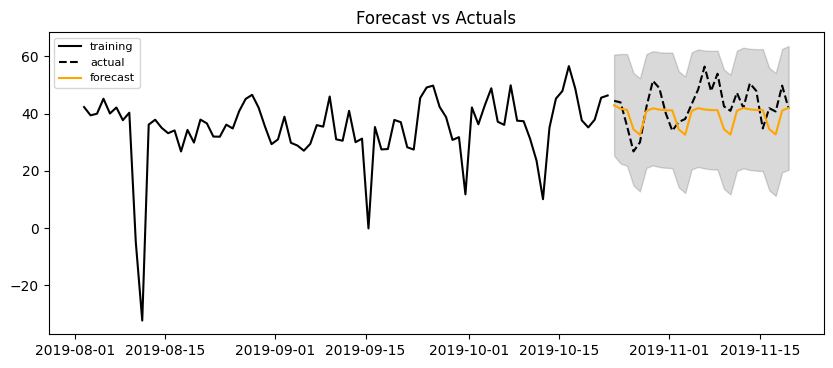

In [143]:
# plot the forecast
forecast = re_compose(forecast)
upper_int = re_compose(confidence_int[:, 1]).price
lower_int = re_compose(confidence_int[:, 0]).price
plot_forecast(forecast, train[train.index > '2019-08-1 11:00:00'], test, lower_int, upper_int)

In [144]:
# define a function for MAPE
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return f'{mape}%' 

In [145]:
get_mape(forecast, test) # this was near 50% for2020

'15.393754001584387%'

### Check residuals for inference validity

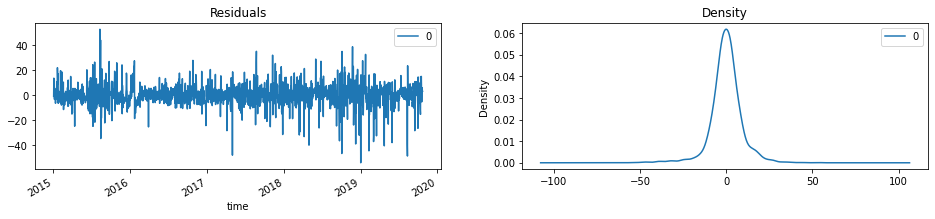

In [34]:
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## SARIMA Model

In [76]:
# Grid search hyper params
smodel = pm.auto_arima(train, seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13516.708, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13323.649, Time=0.76 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13092.703, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13514.712, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13103.004, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.12 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13075.461, Time=2.52 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.15 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13483.049, Time=1.36 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12907.006, Time=3.95 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12923.557, Time=1.98 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12800.216, Time=11.26 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=12798.448, Time=5.74 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=12918.156, Time=1.75 sec
 ARIMA(1,1,1)(2,0,1)[7] inter

In [161]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1,0,1,7), freq='D')
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = sarima.forecast(len(test), alpha=0.05)
confidence_int = results.conf_int()

c:\users\guli\.venvs\lewagon_project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


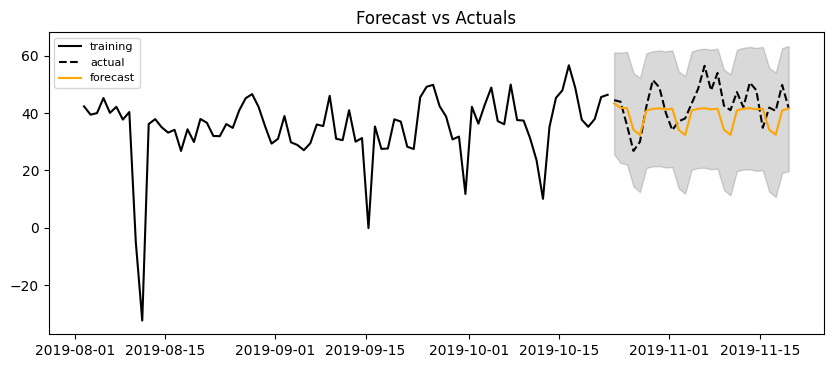

In [162]:
# plot the forecast
plot_forecast(forecast, 
              train[train.index > '2019-08-1 11:00:00'], 
              test, 
              confidence_int['lower price'],
              confidence_int['upper price'])

In [163]:
get_mape(forecast, test)

'18.52240989987389%'

## SARIMAX Model

### Import data

In [167]:
from electricity_price_predictor.data import get_shifted_load, get_weather
df_load = get_shifted_load()
df_load_11 = df_load[df_load.index.hour==11]
df_load_11.head()

,load
time,
2015-01-01 11:00:00,2194.0
2015-01-02 11:00:00,2673.0
2015-01-03 11:00:00,2405.0
2015-01-04 11:00:00,2383.0
2015-01-05 11:00:00,3099.0


In [168]:
df_price = get_shifted_price()
df_price_11 = df_price[df_price.index.hour==11]
df_price_11.head()

,price
time,
2015-01-01 11:00:00,16.08
2015-01-02 11:00:00,15.08
2015-01-03 11:00:00,22.31
2015-01-04 11:00:00,27.32
2015-01-05 11:00:00,40.97


In [170]:
df_weather = get_weather()
df_weather_11 = df_weather[df_price.index.hour==11]
df_weather_11.head()

ValueError: Item wrong length 51689 instead of 51720.

### Decomposition and comparison of price and load

In [44]:
# decompose price and load
decompose_price = seasonal_decompose(df_price_11, model='additive')
decompose_load = seasonal_decompose(df_load_11, model='additive')


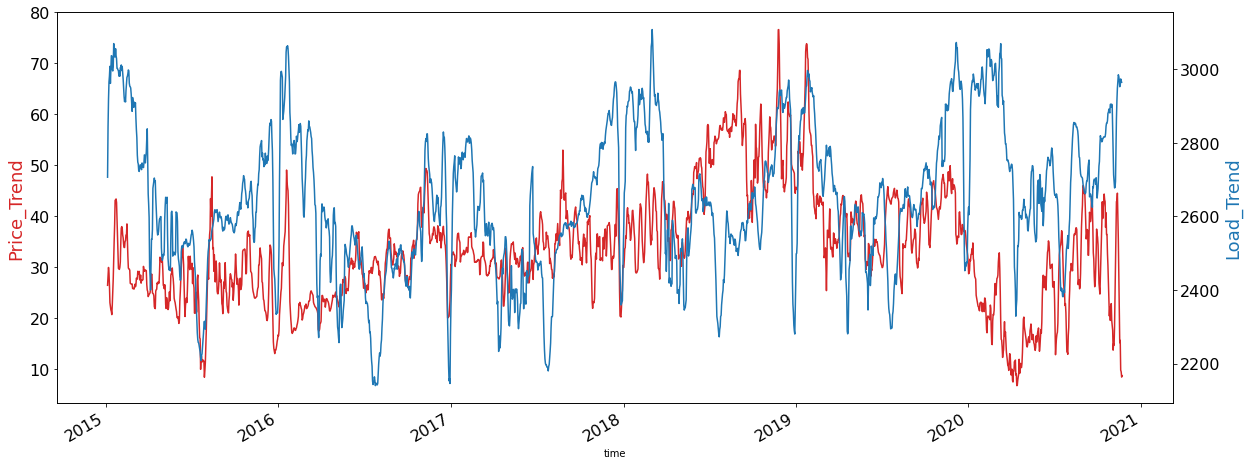

In [74]:
# compare the Trend
fig, ax1 = plt.subplots(figsize=(20,8))
decompose_price.trend.plot(ax=ax1, fontsize=16, color='tab:red')
ax1.set_ylabel('Price_Trend', fontsize=18, color='tab:red')
ax2 = ax1.twinx()
decompose_load.trend.plot(ax=ax2, fontsize=16, color='tab:blue')
ax2.set_ylabel('Load_Trend', fontsize=18, color='tab:blue');

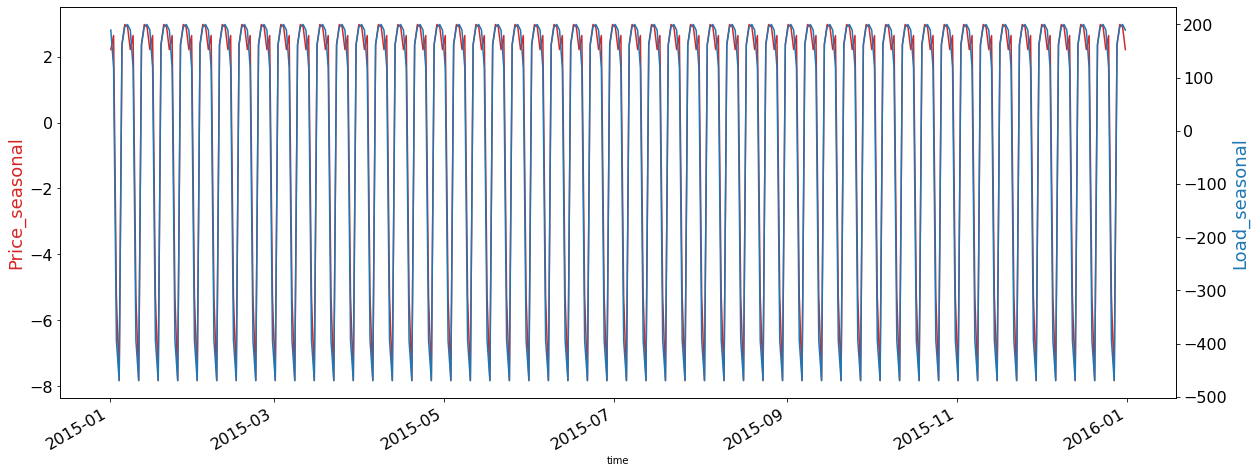

In [75]:
# compare the seasonality
fig, ax1 = plt.subplots(figsize=(20,8))
decompose_price.seasonal.iloc[:365].plot(ax=ax1, fontsize=16, color='tab:red')
ax1.set_ylabel('Price_seasonal', fontsize=18, color='tab:red')
ax2 = ax1.twinx()
decompose_load.seasonal.iloc[:365].plot(ax=ax2, fontsize=16, color='tab:blue')
ax2.set_ylabel('Load_seasonal', fontsize=18, color='tab:blue');

### Grid search

In [173]:
# Grid search hyper params
model = pm.auto_arima(df_price_11, 
                       exogenous=df_load_11,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=16528.414, Time=0.55 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=16273.134, Time=1.21 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=15984.949, Time=2.71 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=16526.416, Time=1.16 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=15983.329, Time=2.33 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=15984.936, Time=3.17 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=15986.866, Time=5.28 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=15811.998, Time=1.84 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=15812.176, Time=4.95 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=15812.293, Time=7.24 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=15813.929, Time=6.38 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=16273.993, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=15813.461, Time=3.16 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=15813.475, Time=3.51 sec
 ARIMA(0,1,2)(0,0,0

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(train_df,
                 order=(3, 0, 0),seasonal_order=(0,1,2,12)
                )
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test_df), alpha=0.05) # 95% confidence
forecast = results.predicted_mean
confidence_int = results.conf_int()

In [ ]:
plot_forecast(forecast, train_df, test_df)

# Prophet

[reference for model_b](https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1)